In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import h5py
from matplotlib import pyplot as plt
from matplotlib.path import Path
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.kernel_ridge import KernelRidge
import scipy
from scipy.constants import physical_constants

In [3]:
def h5group_to_dict(grp):
    dct = {}
    for key, val in grp.items():
        if isinstance(val, h5py.Dataset):
            dct[key] = val[()]
        else:
            dct[key] = h5group_to_dict(val)
    return dct

### Generate Error Table

In [4]:
tab_xc = pd.read_csv("functionals.csv", encoding="UTF-8", index_col=[0])
tab_xc.year = tab_xc.year.fillna(0).astype("int32")

In [15]:
tab_rdf = pd.concat([
    pd.read_csv("Table-RDF-dh.csv", index_col=[0], header=[0, 1]),
    pd.read_csv("Table-RDF-low.csv", index_col=[0], header=[0, 1]),
    pd.read_csv("Table-RDF-wft.csv", index_col=[0], header=[0, 1])]
).loc[tab_xc.index]

In [16]:
ref_etot = pd.Series({
    "B": 63.069, "C": 112.336, "N": 175.259,
    "O": 251.814, "F": 341.988, "Ne": 445.771})

In [18]:
tab_etot = pd.concat([
    pd.read_csv("Table-etot-dh.csv", index_col=[0], header=[0]),
    pd.read_csv("Table-etot-low.csv", index_col=[0], header=[0]),
    pd.read_csv("Table-etot-wft.csv", index_col=[0], header=[0])]
).loc[tab_xc.index]

tab_etot = physical_constants["hartree-electron volt relationship"][0] * (
    tab_etot[["B+3", "C+4", "N+5", "O+6", "F+7", "Ne+8"]] - np.array(tab_etot[["B+1", "C+2", "N+3", "O+4", "F+5", "Ne+6"]])
) - np.array(ref_etot)
tab_etot *= -1

In [8]:
mask_wft = tab_xc["type"] == "WFT"
mask_lda = tab_xc["type"] == "LDA"
mask_gga = tab_xc["type"] == "GGA"
mask_mgga = tab_xc["type"] == "mGGA"
mask_hyb_ex = ~pd.isna(tab_xc["hybrid ex"])
mask_hyb_corr = ~pd.isna(tab_xc["hybrid corr"])

In [90]:
mask_r3 = ~mask_wft & ~mask_hyb_ex
mask_r4 = mask_hyb_ex & ~mask_hyb_corr
mask_r5 = mask_hyb_corr

In [91]:
sum(mask_r3), sum(mask_r4), sum(mask_r5)

(71, 58, 44)

In [19]:
tab_err = tab_xc.copy()
tab_err.columns = pd.MultiIndex.from_tuples([("information", i) for i in tab_xc.columns])
for task in ["RHO", "GRD", "LR"]:
    tab_err[("density maxMNAE", task)] = tab_rdf[task].T.max()
for task in ["RHO", "GRD", "LR"]:
    tab_err[("density meanMNAE", task)] = tab_rdf[task].T.mean()
tab_err[("IP", "RMSE")] = (tab_etot.abs().T**2).mean()**0.5
tab_err[("IP", "MAE")] = tab_etot.abs().T.mean()
tab_err[("IP", "MaxE")] = tab_etot.abs().T.max()

In [21]:
tab_err.to_csv("Table-Summarized.csv")

## Detailed Analysis

In [81]:
# tab_rank = pd.concat([
#     tab_err[~mask_wft]["density maxMNAE"].T.max().rank().astype(int),
#     tab_err[~mask_wft][("IP", "MAE")].rank().astype(int),
# ], axis=1)
# tab_rank.columns = ["density", "IP"]

In [141]:
tab_err.loc["HF"]["density maxMNAE"][["RHO", "GRD"]]

RHO    2.526159
GRD    2.052249
Name: HF, dtype: object

In [142]:
tab_err.loc["HF"]["density maxMNAE"][["RHO"]]

RHO    2.526159
Name: HF, dtype: object

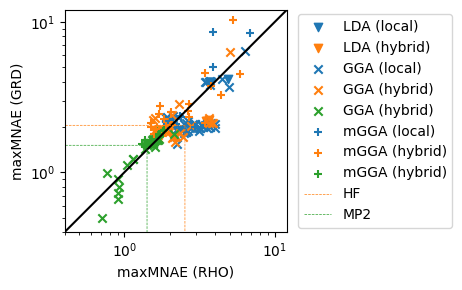

In [154]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot([1e-3, 1e2], [1e-3, 1e2], color="black")
ax.scatter(tab_err[mask_r3 & mask_lda ]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_lda ]["density maxMNAE"]["GRD"], color="C0", marker="v", label= "LDA (local)")
ax.scatter(tab_err[mask_r4 & mask_lda ]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_lda ]["density maxMNAE"]["GRD"], color="C1", marker="v", label= "LDA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_gga ]["density maxMNAE"]["GRD"], color="C0", marker="x", label= "GGA (local)")
ax.scatter(tab_err[mask_r4 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_gga ]["density maxMNAE"]["GRD"], color="C1", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r5 & mask_gga ]["density maxMNAE"]["GRD"], color="C2", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_mgga]["density maxMNAE"]["GRD"], color="C0", marker="+", label="mGGA (local)")
ax.scatter(tab_err[mask_r4 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_mgga]["density maxMNAE"]["GRD"], color="C1", marker="+", label="mGGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r5 & mask_mgga]["density maxMNAE"]["GRD"], color="C2", marker="+", label="mGGA (hybrid)")

ax.plot([0, tab_err.loc["HF"]["density maxMNAE"]["RHO"]], tab_err.loc["HF"]["density maxMNAE"][["RHO", "GRD"]], color="C1", linewidth=0.5, linestyle="--", label="HF")
ax.plot(tab_err.loc["HF"]["density maxMNAE"][["RHO", "GRD"]], [tab_err.loc["HF"]["density maxMNAE"]["GRD"], 0], color="C1", linewidth=0.5, linestyle="--")

ax.plot([0, tab_err.loc["MP2"]["density maxMNAE"]["RHO"]], tab_err.loc["MP2"]["density maxMNAE"][["RHO", "GRD"]], color="C2", linewidth=0.5, linestyle="--", label="MP2")
ax.plot(tab_err.loc["MP2"]["density maxMNAE"][["RHO", "GRD"]], [tab_err.loc["MP2"]["density maxMNAE"]["GRD"], 0], color="C2", linewidth=0.5, linestyle="--")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(0.4, 12)
ax.set_ylim(0.4, 12)
ax.set_aspect(1)

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
ax.set_xlabel("maxMNAE (RHO)")
ax.set_ylabel("maxMNAE (GRD)")

fig.tight_layout()
fig.savefig("../compare-err-RHO-GRD.pdf", transparent=True)

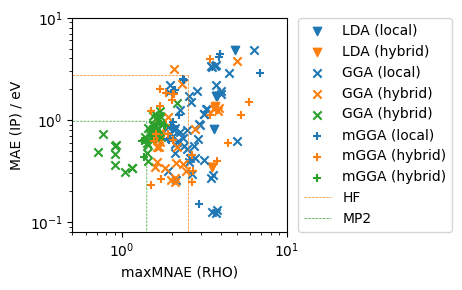

In [163]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(tab_err[mask_r3 & mask_lda ]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_lda ]["IP"]["MAE"], color="C0", marker="v", label= "LDA (local)")
ax.scatter(tab_err[mask_r4 & mask_lda ]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_lda ]["IP"]["MAE"], color="C1", marker="v", label= "LDA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_gga ]["IP"]["MAE"], color="C0", marker="x", label= "GGA (local)")
ax.scatter(tab_err[mask_r4 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_gga ]["IP"]["MAE"], color="C1", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r5 & mask_gga ]["IP"]["MAE"], color="C2", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_mgga]["IP"]["MAE"], color="C0", marker="+", label="mGGA (local)")
ax.scatter(tab_err[mask_r4 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_mgga]["IP"]["MAE"], color="C1", marker="+", label="mGGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r5 & mask_mgga]["IP"]["MAE"], color="C2", marker="+", label="mGGA (hybrid)")

ax.plot([0, tab_err.loc["HF"]["density maxMNAE"]["RHO"]], tab_err.loc["HF"][[("density maxMNAE", "RHO"), ("IP", "MAE")]], color="C1", linewidth=0.5, linestyle="--", label="HF")
ax.plot(tab_err.loc["HF"][[("density maxMNAE", "RHO"), ("IP", "MAE")]], [tab_err.loc["HF"]["IP"]["MAE"], 0], color="C1", linewidth=0.5, linestyle="--")

ax.plot([0, tab_err.loc["MP2"]["density maxMNAE"]["RHO"]], tab_err.loc["MP2"][[("density maxMNAE", "RHO"), ("IP", "MAE")]], color="C2", linewidth=0.5, linestyle="--", label="MP2")
ax.plot(tab_err.loc["MP2"][[("density maxMNAE", "RHO"), ("IP", "MAE")]], [tab_err.loc["MP2"]["IP"]["MAE"], 0], color="C2", linewidth=0.5, linestyle="--")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(0.5, 10)
ax.set_ylim(0.08, 10)
ax.set_box_aspect(1)

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
ax.set_xlabel("maxMNAE (RHO)")
ax.set_ylabel("MAE (IP) / eV")

fig.tight_layout()
# fig.savefig("../compare-err-RHO-GRD.pdf", transparent=True)

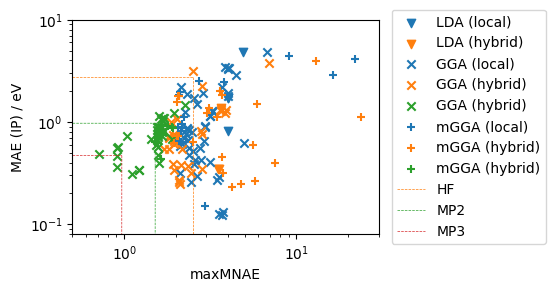

In [189]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(tab_err[mask_r3 & mask_lda ]["density maxMNAE"].T.max(), tab_err[mask_r3 & mask_lda ]["IP"]["MAE"], color="C0", marker="v", label= "LDA (local)")
ax.scatter(tab_err[mask_r4 & mask_lda ]["density maxMNAE"].T.max(), tab_err[mask_r4 & mask_lda ]["IP"]["MAE"], color="C1", marker="v", label= "LDA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_gga ]["density maxMNAE"].T.max(), tab_err[mask_r3 & mask_gga ]["IP"]["MAE"], color="C0", marker="x", label= "GGA (local)")
ax.scatter(tab_err[mask_r4 & mask_gga ]["density maxMNAE"].T.max(), tab_err[mask_r4 & mask_gga ]["IP"]["MAE"], color="C1", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_gga ]["density maxMNAE"].T.max(), tab_err[mask_r5 & mask_gga ]["IP"]["MAE"], color="C2", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_mgga]["density maxMNAE"].T.max(), tab_err[mask_r3 & mask_mgga]["IP"]["MAE"], color="C0", marker="+", label="mGGA (local)")
ax.scatter(tab_err[mask_r4 & mask_mgga]["density maxMNAE"].T.max(), tab_err[mask_r4 & mask_mgga]["IP"]["MAE"], color="C1", marker="+", label="mGGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_mgga]["density maxMNAE"].T.max(), tab_err[mask_r5 & mask_mgga]["IP"]["MAE"], color="C2", marker="+", label="mGGA (hybrid)")

ax.plot([0, tab_err.loc["HF"]["density maxMNAE"].T.max()], [tab_err.loc["HF"]["density maxMNAE"].T.max(), tab_err.loc["HF"][("IP", "MAE")]], color="C1", linewidth=0.5, linestyle="--", label="HF")
ax.plot([tab_err.loc["HF"]["density maxMNAE"].T.max(), tab_err.loc["HF"][("IP", "MAE")]], [tab_err.loc["HF"]["IP"]["MAE"], 0], color="C1", linewidth=0.5, linestyle="--")

ax.plot([0, tab_err.loc["MP2"]["density maxMNAE"].T.max()], [tab_err.loc["MP2"]["density maxMNAE"].T.max(), tab_err.loc["MP2"][("IP", "MAE")]], color="C2", linewidth=0.5, linestyle="--", label="MP2")
ax.plot([tab_err.loc["MP2"]["density maxMNAE"].T.max(), tab_err.loc["MP2"][("IP", "MAE")]], [tab_err.loc["MP2"]["IP"]["MAE"], 0], color="C2", linewidth=0.5, linestyle="--")

ax.plot([0, tab_err.loc["MP3"]["density maxMNAE"].T.max()], [tab_err.loc["MP3"]["density maxMNAE"].T.max(), tab_err.loc["MP3"][("IP", "MAE")]], color="C3", linewidth=0.5, linestyle="--", label="MP3")
ax.plot([tab_err.loc["MP3"]["density maxMNAE"].T.max(), tab_err.loc["MP3"][("IP", "MAE")]], [tab_err.loc["MP3"]["IP"]["MAE"], 0], color="C3", linewidth=0.5, linestyle="--")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(0.5, 30)
ax.set_ylim(0.08, 10)
ax.set_box_aspect(0.7)

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
ax.set_xlabel("maxMNAE")
ax.set_ylabel("MAE (IP) / eV")

fig.tight_layout()
fig.savefig("../compare-err-maxMNAE-MAEIP.pdf", transparent=True)

In [180]:
tab_err[~mask_wft]["IP"]["MAE"].sort_values()[:10]

functional
PBELYP       0.121795
mPWLYP1w     0.124598
PW91LYP      0.131271
TPSSLYP1w    0.152020
M06-2X       0.232841
M08-SO       0.245114
B3LYPV1R     0.248670
RPBE         0.257088
mPW1LYP      0.260684
M05          0.265551
Name: MAE, dtype: float64

In [181]:
tab_err["density maxMNAE"].T.max()[tab_err[~mask_wft]["IP"]["MAE"].sort_values()[:10].index]

functional
PBELYP       3.706911
mPWLYP1w     3.529048
PW91LYP      3.763419
TPSSLYP1w    2.934510
M06-2X       4.213742
M08-SO       4.783833
B3LYPV1R     2.108666
RPBE         2.451630
mPW1LYP      2.068790
M05          5.766840
dtype: float64

In [199]:
tab_err["density maxMNAE"].T.max().sort_values()

functional
CCSD           0.000000
MP4(SDQ)       0.245539
revXYGJ-OS     0.712013
XYG6           0.901323
xDH-PBE0       0.906552
                ...    
MN12-L         8.994762
MN12-SX       13.004112
M11-L         16.267592
MN15-L        21.819811
MN15          23.795075
Length: 178, dtype: float64

In [203]:
tab_err[("IP", "MAE")].T.sort_values()[-20:]

functional
M06-SX      1.990576
Becke       2.178754
OPTX        2.214999
ωB97        2.258392
revM06-L    2.446788
M06-L       2.530564
HF          2.729346
SLYP        2.889052
M11-L       2.909092
ωB97X       3.130847
SPW91       3.292137
SOP         3.354008
SPBE        3.390582
SP86        3.424585
N12-SX      3.762895
MN12-SX     3.955841
MN15-L      4.177324
MN12-L      4.412767
Slater      4.792929
N12         4.841616
Name: (IP, MAE), dtype: float64

In [192]:
tab_err["density maxMNAE"].T[tab_err["density maxMNAE"].T.max().sort_values()[:10].index].T

,RHO,GRD,LR
functional,,,
CCSD,0.000000,0.000000,0.000000
MP4(SDQ),0.245539,0.233093,0.161640
revXYGJ-OS,0.712013,0.499853,0.320192
XYG6,0.901323,0.665436,0.444908
xDH-PBE0,0.906552,0.897644,0.668525
XYGJ-OS,0.907952,0.733366,0.674218
XYG5,0.923516,0.802816,0.519950
MP3,0.881324,0.967352,0.718420
XYGJ-OS5,0.771090,0.995833,1.032277


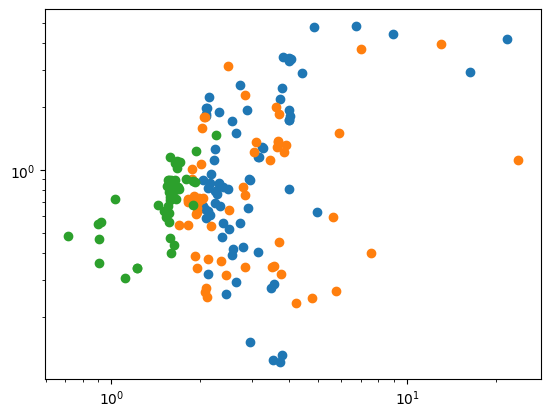

In [114]:
fig, ax = plt.subplots()
ax.scatter(tab_err[mask_r3]["density maxMNAE"].T.max(), tab_err[mask_r3][("IP", "MAE")])
ax.scatter(tab_err[mask_r4]["density maxMNAE"].T.max(), tab_err[mask_r4][("IP", "MAE")])
ax.scatter(tab_err[mask_r5]["density maxMNAE"].T.max(), tab_err[mask_r5][("IP", "MAE")])
ax.set_yscale("log")
ax.set_xscale("log")

In [97]:
tab_err[mask_r3]["density maxMNAE"].rank().astype(int).sort_values("RHO")[:10]

,RHO,GRD,LR
functional,,,
OVWN,1,52,23
OPZ81,2,53,24
OLYP,3,40,11
TPSSm,4,28,5
OVWN1RPA,5,54,25
MS2,6,42,21
TPSS,7,22,4
OPTX,8,45,9
revTPSS,9,23,3


In [102]:
tab_err[mask_r3]["density maxMNAE"].rank().astype(int).T.mean().sort_values()[:15]

functional
HCTH407     8.666667
MOHLYP      9.666667
TPSS       11.000000
revTPSS    11.666667
TPSSm      12.333333
OLYP       18.000000
EDF1       19.000000
RSCAN      19.666667
r++SCAN    20.333333
PBE        20.666667
OPTX       20.666667
BPBE       21.333333
R2SCAN     22.333333
PBEPW91    22.333333
PW91PBE    22.666667
dtype: float64

In [105]:
tab_err[~mask_wft]["density maxMNAE"].rank().astype(int).T.mean().sort_values()[:15]

functional
revXYGJ-OS           1.000000
XYG6                 2.333333
xDH-PBE0             4.333333
XYGJ-OS              4.333333
XYG5                 4.333333
XYGJ-OS5             5.666667
revXYG3              6.666667
lrc-XYG3             8.000000
XYG3                 8.333333
DSD-PBEPBE-D3BJ     11.333333
DSD-PBEB95-D3BJ     14.666667
DSD-BLYP-D3BJ       16.666667
DSD-PBEP86-D3BJ     17.000000
SOS0-PBE-QIDH       18.666667
SOS-RSX-PBE-QIDH    20.666667
dtype: float64